## Install Dependencies

In [ ]:
!pip install ultralytics supervision opencv-python-headless norfair --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.2 MB/s eta 0:00:00
   

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from norfair import Detection, Tracker, Video, draw_tracked_objects
from norfair.distances import mean_euclidean
import supervision as sv
import os
from collections import defaultdict
from IPython.display import Video as IPVideo, display
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import defaultdict

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Sample Video Path

In [ ]:
input_video_path = "/content/drive/MyDrive/Ostad - Projects/OD_Shoaib/people-walking.mp4"

## Load Model (YOLO11)

In [ ]:
model = YOLO("yolo11n-seg.pt")

## Tracker Setup (NORFAIR)

In [ ]:
tracker = Tracker(distance_function=mean_euclidean, distance_threshold=30)

## Initialize Utilites

In [ ]:
line_in_y = 160
line_out_y = 250

in_count, out_count = 0, 0
object_paths = defaultdict(list)
heatmap = None

counted_ids_in = set()
counted_ids_out = set()

frame_count = 0

## Video Reader - Writer Setup

In [ ]:
video_cap = cv2.VideoCapture(input_video_path)

width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video_cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*"mp4v")

output_video_path = "/content/drive/MyDrive/Ostad - Projects/OD_Shoaib/output_people_flow.mp4"
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

heatmap_video_path = "/content/drive/MyDrive/Ostad - Projects/OD_Shoaib/heatmap_video.mp4"
heatmap_writer = cv2.VideoWriter(heatmap_video_path, fourcc, fps, (width, height))

# Initialize heatmap and other variables
heatmap = np.zeros((height, width), dtype=np.float32)
object_paths = defaultdict(list)

## Main Loop

In [ ]:
while True:
    ret, frame = video_cap.read()
    if not ret:
        break

    if frame_count == 0:
        first_frame_path = "/content/drive/MyDrive/Ostad - Projects/OD_Shoaib/first_frame.jpg"
        cv2.imwrite(first_frame_path, frame)

    # Detection and tracking (replace with your actual detection/tracking code)
    results = model(frame, classes=[0], conf=0.25, verbose=False)[0]
    detections = []
    centers = []

    for det in results.boxes.data.tolist():
        x1, y1, x2, y2, conf, cls = det
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)
        centers.append((cx, cy))
        detections.append(Detection(points=np.array([[cx, cy]]), scores=np.array([conf])))

    tracked_objects = tracker.update(detections=detections)

    for obj in tracked_objects:
        ID = obj.id
        cx, cy = obj.estimate[0]
        cx, cy = int(cx), int(cy)
        object_paths[ID].append((cx, cy))

        cv2.circle(frame, (cx, cy), 4, (0, 255, 0), -1)
        cv2.putText(frame, f"ID {ID}", (cx - 10, cy - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        if len(object_paths[ID]) >= 2:
            y_previous = object_paths[ID][-2][1]
            y_current = cy

            # Check for crossing IN line without double counting
            if (ID not in counted_ids_in) and (y_previous < line_in_y <= y_current):
                in_count += 1
                counted_ids_in.add(ID)

            # Check for crossing OUT line without double counting
            elif (ID not in counted_ids_out) and (y_previous > line_out_y >= y_current):
                out_count += 1
                counted_ids_out.add(ID)

    cv2.line(frame, (0, line_in_y), (width, line_in_y), (0, 255, 255), 2)
    cv2.line(frame, (0, line_out_y), (width, line_out_y), (255, 0, 255), 2)

    cv2.putText(frame, f"IN: {in_count}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
    cv2.putText(frame, f"OUT: {out_count}", (10, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)

    # Update heatmap counts
    for (cx, cy) in centers:
        heatmap[cy, cx] += 1

    # Generate heatmap frame
    heatmap_blur = cv2.GaussianBlur(heatmap, (0, 0), sigmaX=15, sigmaY=15)
    heatmap_norm = cv2.normalize(heatmap_blur, None, 0, 255, cv2.NORM_MINMAX)
    heatmap_colored = cv2.applyColorMap(heatmap_norm.astype(np.uint8), cv2.COLORMAP_JET)
    heatmap_overlay = cv2.addWeighted(heatmap_colored, 1.0, np.zeros_like(heatmap_colored), 0.0, 0)

    # Write output videos
    video_writer.write(frame)
    heatmap_writer.write(heatmap_overlay)

    frame_count += 1

# After loop ends - release resources
video_cap.release()
video_writer.release()
heatmap_writer.release()

## Show & Save Final Heatmap

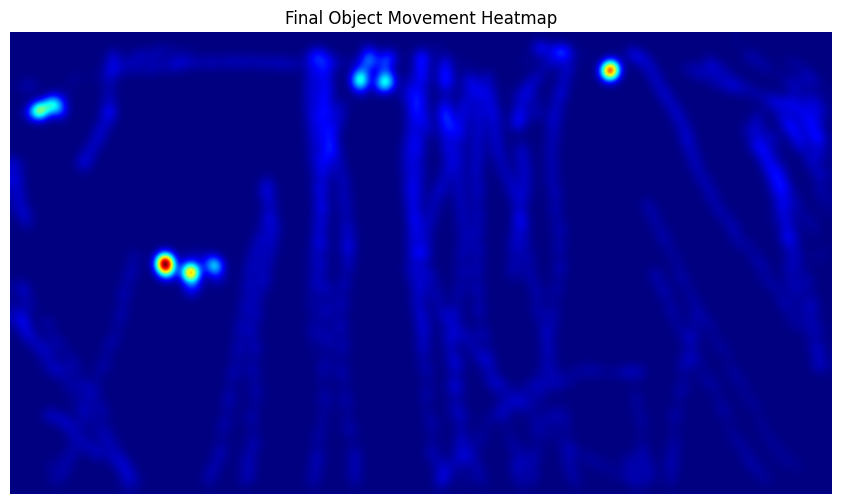

In [ ]:
# Save and display final heatmap image
final_heatmap_path = "/content/drive/MyDrive/Ostad - Projects/OD_Shoaib/final_heatmap.png"
cv2.imwrite(final_heatmap_path, heatmap_overlay)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(heatmap_overlay, cv2.COLOR_BGR2RGB))
plt.title("Final Object Movement Heatmap")
plt.axis("off")
plt.show()

## Zone-based Movement Intensity (Quadrants)

Zone-based Movement Intensity:
Top-Left: 379536 movement pixels
Top-Right: 471813 movement pixels
Bottom-Left: 420124 movement pixels
Bottom-Right: 475420 movement pixels


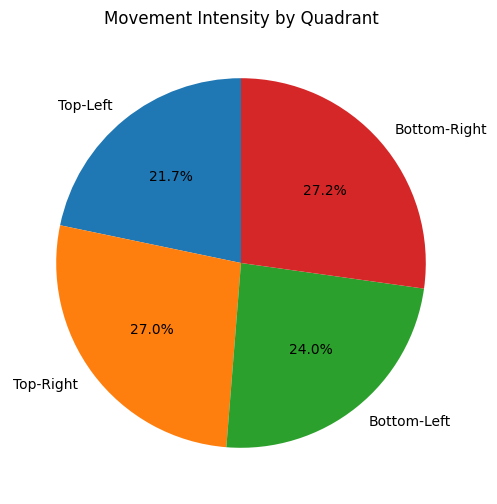

In [ ]:
# Use the normalized grayscale heatmap (heatmap_norm)
H, W = heatmap_norm.shape
half_H, half_W = H // 2, W // 2

# Define quadrants
Q1 = heatmap_norm[:half_H, :half_W]      # Top-left
Q2 = heatmap_norm[:half_H, half_W:]      # Top-right
Q3 = heatmap_norm[half_H:, :half_W]      # Bottom-left
Q4 = heatmap_norm[half_H:, half_W:]      # Bottom-right

# Count movement pixels (non-zero intensities)
zone_counts = {
    "Top-Left": np.count_nonzero(Q1),
    "Top-Right": np.count_nonzero(Q2),
    "Bottom-Left": np.count_nonzero(Q3),
    "Bottom-Right": np.count_nonzero(Q4)
}

# Print counts
print("Zone-based Movement Intensity:")
for zone, count in zone_counts.items():
    print(f"{zone}: {count} movement pixels")

# Optional Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(zone_counts.values(), labels=zone_counts.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Movement Intensity by Quadrant")
plt.show()

## Overlay Heatmap on First Frame

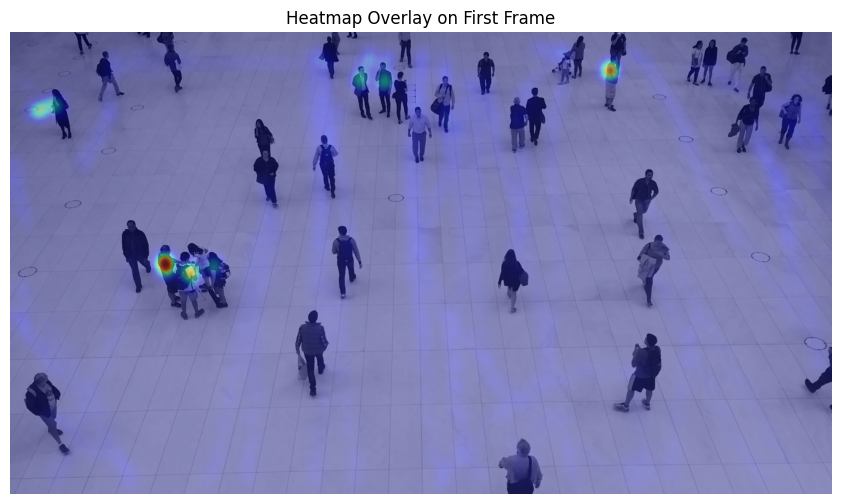

In [ ]:
first_frame = cv2.imread('/content/drive/MyDrive/Ostad - Projects/OD_Shoaib/first_frame.jpg')  # fallback in case not captured earlier

if first_frame is not None and heatmap_overlay is not None:
    # Resize heatmap to match frame size if needed
    heatmap_resized = cv2.resize(heatmap_overlay, (first_frame.shape[1], first_frame.shape[0]))
    overlayed_frame = cv2.addWeighted(first_frame, 0.6, heatmap_resized, 0.4, 0)

    overlay_path = "/content/drive/MyDrive/Ostad - Projects/OD_Shoaib/overlay_on_first_frame.png"
    cv2.imwrite(overlay_path, overlayed_frame)

    # Show overlay
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(overlayed_frame, cv2.COLOR_BGR2RGB))
    plt.title("Heatmap Overlay on First Frame")
    plt.axis("off")
    plt.show()

## Save in Local

In [ ]:
import shutil

local_path = "/content/output_video.mp4"
local_path2 = "/content/output_heatmap.mp4"
shutil.copy(output_video_path, local_path)
shutil.copy(heatmap_video_path, local_path2)

'/content/output_heatmap.mp4'

## Video Saving Confirmation - Showing One Frame

Video opened successfully, showing one frame:


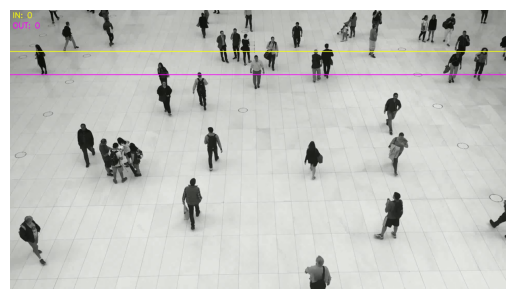

In [ ]:
import cv2

cap = cv2.VideoCapture(local_path)
if not cap.isOpened():
    print("Error: Cannot open video file")
else:
    ret, frame = cap.read()
    if ret:
        print("Video opened successfully, showing one frame:")
        from matplotlib import pyplot as plt
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("Cannot read the first frame.")
cap.release()

Video opened successfully, showing one frame:


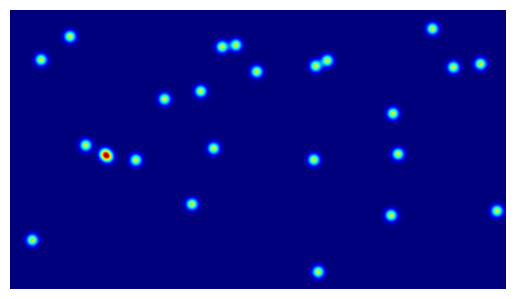

In [ ]:
import cv2

cap = cv2.VideoCapture(local_path2)
if not cap.isOpened():
    print("Error: Cannot open video file")
else:
    ret, frame = cap.read()
    if ret:
        print("Video opened successfully, showing one frame:")
        from matplotlib import pyplot as plt
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("Cannot read the first frame.")
cap.release()

## Converting Video to Show in Colab

In [ ]:
!ffmpeg -y -i "/content/output_video.mp4" -vcodec libx264 -acodec aac -strict -2 "/content/output_video_converted.mp4"

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
!ffmpeg -y -i "/content/output_heatmap.mp4" -vcodec libx264 -acodec aac -strict -2 "/content/output_heatmap_converted.mp4"

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

## Output Video

## Out Heatmap Video

# Readme:
This project detects and tracks people in a video stream using YOLOv11-seg and Norfair tracking library, determines their movement direction (IN or OUT), and generates a heatmap visualizing the density of movements across the frame.

## It also produces:

Annotated video with object tracking and ID overlays.

Real-time IN/OUT count using virtual lines.

A final heatmap video showing footfall intensity.

## Detection Method
We used YOLOv11-seg, a state-of-the-art deep learning model designed for:

Person Detection using classes=[0]

High-speed inference for real-time analysis

Bounding box outputs are processed to extract object centers

The center points of the bounding boxes are used for Norfair Tracking, which assigns persistent IDs to detected people across frames.

Object Tracking & Heatmap
The tracker maintains trajectories per person using unique IDs.

Each detected center (cx, cy) is stored and accumulated into a heatmap.

Gaussian blur is applied to smoothen the final heatmap.

The heatmap is then overlayed on the first frame for visualization.

Line Coordinates
Two horizontal virtual lines are defined in the frame:

python
Copy
Edit
line_in_y = 160
line_out_y = 250
line_in_y: used to detect people entering the monitored area

line_out_y: used to detect people exiting the monitored area

Logic for IN/OUT Counting
Each object's center position history is stored as object_paths[object_id].

We compare the current and previous Y-coordinate:

IN: if a person crosses from above to below line_in_y

OUT: if a person crosses from below to above line_out_y

python
Copy
Edit
if y_previous < line_in_y <= y_current:
    in_count += 1
elif y_previous > line_out_y >= y_current:
    out_count += 1
This ensures accurate directional movement tracking.

Highlights
Live display of object IDs and IN/OUT counts

Object path tracking and center markings

Final heatmap shows most visited/dense regions

Outputs
tracked_output.mp4: Person tracking with ID, direction, and IN/OUT counts

heatmap_output.mp4: Footfall heatmap overlayed on the first frame